In [27]:
import sys
sys.path.append('/Users/sunjs/Desktop/big_data2020/homeworks/hm_ii/fire_pytools')

In [28]:
from pylab import *

from import_kf.kf_factors import *

import data_setup.stock_annual as stock_annual
import data_setup.stock_monthly as stock_monthly

from utils.monthly_date import *

from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios

desired_width = 10
pd.set_option('display.width', desired_width)
idx = pd.IndexSlice

In [29]:
# %% Set Up

char_breakpoints = {'me': [0.5],
                    'beme': [0.3, 0.7],
                    'opbe': [0.3, 0.7],
                    'inv': [0.3, 0.7]}

weightvar = 'melag_weights'

retvar = 'retadj'

dict_factors = {'beme': 'hml',
                'me': 'smb',
                'opbe': 'rmw',
                'inv': 'cma'}

In [34]:
# %% Download Data
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100

# Annual Data

varlist = ['conm', 'fyear', 'fyr', 'at', 'capx', 'ceq', 'cogs', 'dlc', 'ib', 'icapt', 'itcb', 'lt', 'mib',
            'naicsh', 'pstk', 'pstkl', 'pstkrv',  'sale', 'seq', 'sich', 'sstk', 'txdb', 'txdi', 'txditc',
            'xint', 'xsga']

adata = stock_annual.main(varlist=varlist, complete_table=False)

# Monthly Data
mdata = stock_monthly.main()

Stock annual calculation started.
Enter your WRDS username [sunjs]:jiashu
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done
Compustat data was successfully downloaded in 105.83586311340332 seconds.
Pension data was successfully downloaded in 2.9948630332946777 seconds.
CRSP data was successfully downloaded in 209.88396406173706 seconds.
CRSP and Compsuat merge created 6 (fyear, permno) duplicates.
Keeping only the last available datadate per PERMNO.
There are 81664 PERMNOs without a valid PERMCO in DFF BE data: not present in the stock names table.
Number of not valid PERMCOs in lcomp: 0
Number of entries with valis sich:
0.0457
Number of entries with valis sich_filled:
0.003
Time to create stock_annual: 356.3699400424957 seconds
Stock monthly calculation started.
Enter your WRDS username [sunjs]:jiashu
Enter your password:········
WRDS recommend

In [35]:
# Set names
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) #inv_permco
mdata.rename(columns={weightvar: 'weightvar', retvar: 'retvar'}, inplace=True)
# %% Create Filters
# Global Filters: applied to all portfolio sorts

# valid return
# ------------
print('Data deleted due to missing return: %f' % np.round(mdata.retvar.isnull().mean()*100, 2))
rdata = mdata[mdata.retvar.notnull()]

# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]

del adata, mdata

Data deleted due to missing return: 3.310000
Data deleted due to shrcd: 23.390000
Data deleted due to exchcd: 1.560000


In [36]:
# Portfolio Specif Filters
sortvars = [*char_breakpoints]

# Define the break point filters
# ------------------------------
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

# Define the sample filter
# ------------------------
sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    # notice that the way we defined beme or beme is null if be<=0
    bp_filters[sortvar] = (sort_data[sortvar].notnull())
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0) & (sort_data[sortvar].notnull()))

In [37]:
# %% Find Breakpoints
# The number of firms Ken French reports for each characteristic sort varies. This means his universe of stocks
# for sorting changes across characteristics. That is why we need to calculate breakpoints separately.
breakpoints = [None] * len(sortvars)
breakpoints = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    breakpoints[sortvar] = find_breakpoints(data=sort_data[bp_filters[sortvar]],
                                            quantiles={sortvar: char_breakpoints[sortvar]},
                                            id_variables=['rankyear', 'permno', 'exchcd'],
                                            exch_cd=[1]
                                            )

NYSE breakpoints were calculated for me.
NYSE breakpoints were calculated for beme.
NYSE breakpoints were calculated for opbe.
NYSE breakpoints were calculated for inv.


In [38]:
# %% Portfolio Sorts
portsorts = [None] * len(sortvars)
portsorts = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    portsorts[sortvar] = sort_portfolios(data=sort_data[sample_filters[sortvar]],
                                         quantiles={sortvar: char_breakpoints[sortvar]},
                                         id_variables=['rankyear', 'permno', 'exchcd'],
                                         breakpoints={sortvar: breakpoints[sortvar]}
                                         )
    
# merge all separate portfolio allocations together
port = portsorts['me'].copy()
for sortvar in sortvars[1:]:
    # Notice that this is an outer join
    # why these dataframes have different shapes? 
    port = port.merge(portsorts[sortvar], on=['permno', 'rankyear'], how='outer')

Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1951.0
Stocks were sorted according to breakpoints, starting in 1952.0


In [61]:
# %% Calculate rertuns
# Notice that this is a inner join
port_ret = pd.merge(port, rdata, on=['rankyear', 'permno'], how = 'inner')

# TODO: calculate returns of long-short portfolios (SMB, HML, RMW, CMA)
res = {}
port_ret_mini = port_ret[['date','retvar','meportfolio','bemeportfolio','invportfolio','opbeportfolio','lag_me']]
for sortvar in sortvars[1:]:  
    new_var = sortvar + 'portfolio' 
    port_ret_mini = port_ret_mini[(port_ret_mini.lag_me.notnull()) & (port_ret_mini.retvar.notnull())]    
    tmp = port_ret_mini.groupby(['date', 'meportfolio', new_var]).apply(
        lambda x: np.average(x['retvar'], weights = x['lag_me'])).unstack(level=[1, 2])
    res[sortvar] = tmp

## Question 1 (25 pts)

For each one of the the 3 characteristics (BEME, OP and INV), plot the time series of cumulative log-returns for each of the 6 value-weight portfolios (BEME X ME, OP X ME and INV X ME).

For all questions consider the time period from 1963 to 2019.

In [62]:
for sortvar, ret in res.items():
    res[sortvar] = ret['1963':'2019']

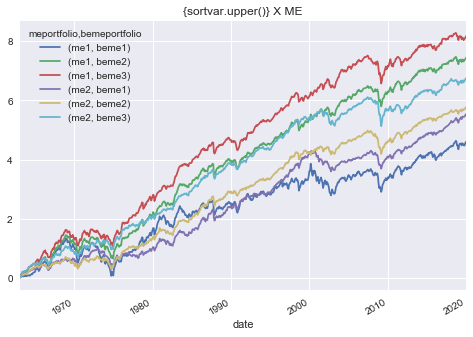

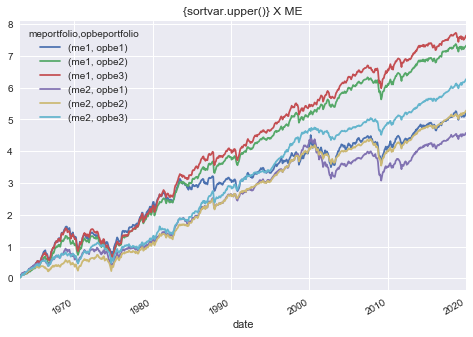

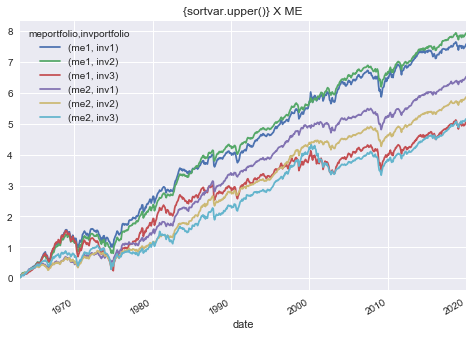

In [72]:
plt.style.use('seaborn')
for sortvar in ['beme', 'opbe', 'inv']:
    np.log(1+res[sortvar]).cumsum().plot(grid=True, title = 'Market Returns')
    plt.title("{sortvar.upper()} X ME") ## chagne
    plt.show()

## Question 2 (25 pts)

Plot the time series of cumulative log-returns for each of the 3 SMB components, i.e., $SMB_{BEME}$, $SMB_{OP}$ and $SMB_{INV}$.

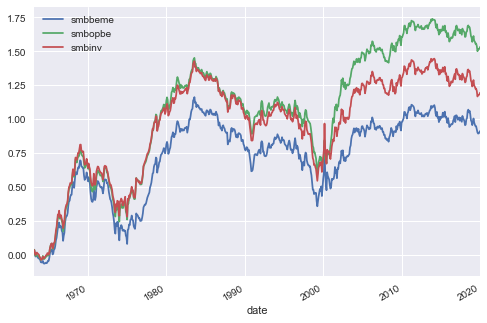

In [77]:
SMB_comp = {}
for sortvar in ['beme', 'opbe', 'inv']:
    new_var = "smb" + sortvar
    SMB_comp[new_var] = (res[sortvar].loc[:, idx['me1', :]].mean(axis=1) - 
                              res[sortvar].loc[:, idx['me2', :]].mean(axis=1))
SMB_comp = pd.DataFrame(SMB_comp)
np.log(1+SMB_comp).cumsum().plot()

## Question 3 (25 pts)

Plot the time series of cumulative log-returns for each of the 4 factors, i.e., SMB, HML, RMW and INV.

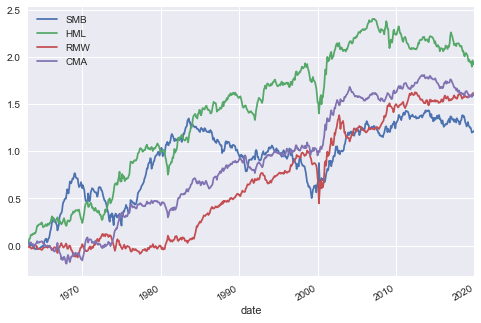

In [222]:
ff_factors = dict()
ff_factors['SMB'] = SMB_comp.mean(axis=1)
ff_factors['HML'] = (res['beme'].loc[:, idx[:, "beme3"]].mean(axis=1) - 
                  res['beme'].loc[:, idx[:, "beme1"]].mean(axis=1))
ff_factors['RMW'] = (res['opbe'].loc[:, idx[:, "opbe3"]].mean(axis=1) - 
                  res['opbe'].loc[:, idx[:, "opbe1"]].mean(axis=1))
ff_factors['CMA'] = (res['inv'].loc[:, idx[:, "inv1"]].mean(axis=1) - 
                  res['inv'].loc[:, idx[:, "inv3"]].mean(axis=1))

ff_factors = pd.DataFrame(ff_factors)
np.log(1+ff_factors).cumsum().plot()

## Question 4 (25 pts)

Compare your factor with the ones reported in Ken French's website. Report the mean, volatility, Sharpe-ratio and correlations.

In [ ]:
# Mean, volatility, sharpe-ratio of our factors

In [223]:
ff_factors.index = ff_factors.index.strftime('%Y%m').astype(int)
result = pd.DataFrame()
result['mean'] = ff_factors.mean()
ff_std_raw = ff_factors.std()
result['std'] = ff_std_raw
# Sharpe ratio
ff_factors_rf = ff_factors.subtract(ff_ret.RF, axis=0).dropna()
result['Sharpe'] = ff_factors_rf.mean()/ff_factors_rf.std()

In [224]:
result

,mean,std,Sharpe
SMB,0.002223,0.029573,-0.051992
HML,0.003231,0.028033,-0.024919
RMW,0.002616,0.022594,-0.048173
CMA,0.002543,0.019661,-0.063783


In [ ]:
# Compared with ff_factors in ff_ret
# ff_ret

In [225]:
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100
result_ff_ret = pd.DataFrame()
result_ff_ret['mean'] = ff_ret.mean()
result_ff_ret['std'] = ff_ret.std()
ff_ret_rf = ff_ret.subtract(ff_ret.RF, axis = 0).dropna()
result_ff_ret['Sharpe'] = ff_ret_rf.mean() / ff_ret_rf.std()

In [226]:
result_ff_ret.iloc[1:5,:]

,mean,std,Sharpe
SMB,0.002210,0.030095,-0.051850
HML,0.002944,0.028173,-0.029804
RMW,0.002567,0.021554,-0.055957
CMA,0.002705,0.019928,-0.054079


In [ ]:
# Correlation

In [227]:
ff_factors.corrwith(ff_ret).dropna()

SMB    0.998279
HML    0.996095
RMW    0.987860
CMA    0.982394
dtype: float64